In [ ]:
# Importa algumas das bibliotecas necessárias
!pip install shap
import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Monta o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Recebe os csvs e os transforma e dfs
df_d = pd.read_csv('/content/drive/MyDrive/2023-1A-T05/GRUPOS/Grupo 4 - G4/Datasets/tabelas/BDIPMamaV11-INTELIDemograficosTt_DATA_LABELS_2023-01-24_1922.csv')
df_h = pd.read_csv('/content/drive/MyDrive/2023-1A-T05/GRUPOS/Grupo 4 - G4/Datasets/tabelas/BDIPMamaV11-INTELIHistopatologia_DATA_LABELS_2023-01-24_1924.csv')
df_p = pd.read_csv('/content/drive/MyDrive/2023-1A-T05/GRUPOS/Grupo 4 - G4/Datasets/tabelas/BDIPMamaV11-INTELIPesoEAltura_DATA_LABELS_2023-01-24_1926.csv')
df_t = pd.read_csv('/content/drive/MyDrive/2023-1A-T05/GRUPOS/Grupo 4 - G4/Datasets/tabelas/BDIPMamaV11-INTELIRegistroDeTumo_DATA_LABELS_2023-01-24_1924.csv')

# Exploração dos Dados

## Funções Utilitárias
Funções que tem o objetivo de facilitar a exploração de dados

In [ ]:
def replace_arr(base_str, values_to_replace, replace_str):
  for value in values_to_replace:
    base_str = base_str.replace(value, replace_str)
  return base_str

def normalize_columns_name(df):
  columns = []
  for column in df.columns:
    column = column.lower().strip()
    column = replace_arr(column, [
        '?', '(', ')', '!', 'º', '[', ']', '%', '>', '<', ':', ',', ';', '.', '#', '/' 
    ], '')
    column = replace_arr(column, [
        'á', 'à', 'â', 'ã',
    ], 'a')
    column = replace_arr(column, [
        'é', 'è', 'ê',
    ], 'e')
    column = replace_arr(column, [
        'í', 'ì',
    ], 'i')
    column = replace_arr(column, [
        'ó', 'ò', 'ô', 'õ'
    ], 'o')
    column = replace_arr(column, [
        'ú', 'ù', 'û'
    ], 'u')
    column = replace_arr(column, [
        '-', ' ', '=', ',', '__', '__'
    ], '_')
    column = replace_arr(column, [
        'ç'
    ], 'c')

    if column[-1] == '_':
      column = column[:-1]

    if column[0] == '_':
      column = column[1:]
    
    columns.append(column)

  df.columns = columns
  return df

def alterar_tipo_da_coluna(df, column, column_type):
  df[column] = df[column].astype(column_type)

def column_as_numeric(column):
  return pd.to_numeric(column, errors='coerce').fillna(0)

def get_info(df):
  df = df.loc[:]
  col_info = []
    
  for col in df.columns:
    column = df[col]
    null_count = column.isnull().sum()
    null_percent = round((null_count / len(df)) * 100, 2)
    col_dict = {
        'nome': col,
        'tipo': column.dtype,
        'quantidade_nulos': null_count,
        'porcentagem_nulos': null_percent,
        'quantidade_preenchido': column.count(),
        'porcentagem_preenchido': (column.count() / len(df)) * 100,
        'quantidade_valores_distintos': column.nunique(),
        'min': column_as_numeric(column).min(),
        'max': column_as_numeric(column).max(),
        'media': column_as_numeric(column).mean(),
        'mediana': column_as_numeric(column).median()
    }
    col_info.append(col_dict)
    
  col_info_df = pd.DataFrame(col_info)

  alterar_tipo_da_coluna(col_info_df, 'porcentagem_nulos', 'float16')
  alterar_tipo_da_coluna(col_info_df, 'porcentagem_preenchido', 'float16')
    
  return col_info_df

def value_counts_buffado(df, dropna=False):
  for column in df.columns:
    counts = df[column].value_counts(dropna=dropna)
    percs = df[column].value_counts(normalize=True, dropna=dropna).mul(100)
    print('\n' + column + '\n\n', pd.concat([counts,percs], axis=1, keys=['count', 'percentage']))

## Demográficos
Dados gerais dos paciente.

df_f

In [ ]:
# Aplica a função que normaliza o nome das colunas
normalize_columns_name(df_d)
# Renomeia as colunas normalizadas
df_d = df_d.rename(columns={
  'tempo_de_seguimento_em_dias_desde_o_ultimo_tumor_no_caso_de_tumores_multiplos_dt_pci': 'dias_desde_ultimo_tumor_ctm_dt_pci',
  'historia_familiar_de_cancer_relacionado_a_sindrome_de_cancer_de_mama_e_ovario_hereditaria_choice_sim_1_grau_apenas_1_caso': 'hered_mama_ovario_grau_1_1_caso',
  'historia_familiar_de_cancer_relacionado_a_sindrome_de_cancer_de_mama_e_ovario_hereditaria_choice_sim_1_grau_mais_de_1_caso': 'hered_mama_ovario_grau_1_n_caso',
  'historia_familiar_de_cancer_relacionado_a_sindrome_de_cancer_de_mama_e_ovario_hereditaria_choice_sim_2_grau_apenas_1_caso': 'hered_mama_ovario_grau_2_1_caso',
  'historia_familiar_de_cancer_relacionado_a_sindrome_de_cancer_de_mama_e_ovario_hereditaria_choice_sim_2_grau_apenas_1_caso': 'hered_mama_ovario_grau_2_n_caso',
  'grau_de_parentesco_de_familiar_com_cancer_choice_primeiro_pais_irmaos_filhos': 'cancer_1_grau_parent',
  'grau_de_parentesco_de_familiar_com_cancer_choice_segundo_avos_tios_e_netos': 'cancer_2_grau_parent',
  'grau_de_parentesco_de_familiar_com_cancer_choice_terceiro_bisavos_tio_avos_primos_sobrinhos': 'cancer_3_grau_parent',
  'idade_do_paciente_ao_primeiro_diagnostico': 'idade_primeiro_diagnostico'
})

get_info(df_d)

,nome,tipo,quantidade_nulos,porcentagem_nulos,quantidade_preenchido,porcentagem_preenchido,quantidade_valores_distintos,min,max,media,mediana
0,record_id,int64,0,0.000000,4272,100.000000,4272,302.0,82240.0,48652.360487,53394.0
1,repeat_instrument,float64,4272,100.000000,0,0.000000,0,0.0,0.0,0.000000,0.0
2,repeat_instance,float64,4272,100.000000,0,0.000000,0,0.0,0.0,0.000000,0.0
3,escolaridade,object,215,5.031250,4057,94.937500,6,0.0,0.0,0.000000,0.0
4,idade_primeiro_diagnostico,float64,180,4.210938,4092,95.812500,76,0.0,98.0,51.962079,53.0
5,sexo,object,147,3.439453,4125,96.562500,2,0.0,0.0,0.000000,0.0
6,raca_declarada_biobanco,object,4038,94.500000,234,5.476562,5,0.0,0.0,0.000000,0.0
7,uf_de_nascimento_do_paciente,object,4270,99.937500,2,0.046814,1,0.0,0.0,0.000000,0.0
8,uf_de_residencia_do_paciente,object,4270,99.937500,2,0.046814,1,0.0,0.0,0.000000,0.0
9,data_da_ultima_informacao_sobre_o_paciente,object,2,0.049988,4270,99.937500,2131,0.0,0.0,0.000000,0.0


In [ ]:
# Chama a função que realiza um value counts com informações adicionais
value_counts_buffado(df_d[['data_da_ultima_informacao_sobre_o_paciente', 'ultima_informacao_do_paciente']])


data_da_ultima_informacao_sobre_o_paciente

             count  percentage
2020-07-08      9    0.210674
2020-05-26      7    0.163858
2020-01-25      7    0.163858
2019-12-26      7    0.163858
2020-04-30      7    0.163858
...           ...         ...
2017-03-18      1    0.023408
2017-07-06      1    0.023408
2017-07-30      1    0.023408
2017-07-11      1    0.023408
2022-06-10      1    0.023408

[2132 rows x 2 columns]

ultima_informacao_do_paciente

                               count  percentage
Vivo, SOE                      2815   65.894195
Obito por câncer               1131   26.474719
Vivo, com câncer                235    5.500936
Óbito por outras causas, SOE     89    2.083333
NaN                               2    0.046816


In [ ]:
df_d

,record_id,repeat_instrument,repeat_instance,escolaridade,idade_primeiro_diagnostico,sexo,raca_declarada_biobanco,uf_de_nascimento_do_paciente,uf_de_residencia_do_paciente,data_da_ultima_informacao_sobre_o_paciente,...,cancer_3_grau_parent,regime_de_tratamento,hormonioterapia,data_da_cirurgia,tipo_de_terapia_anti_her2_neoadjuvante,radioterapia,data_de_inicio_do_tratamento_quimioterapia,esquema_de_hormonioterapia,data_do_inicio_hormonioterapia_adjuvante,data_de_inicio_da_radioterapia
0,302,NaN,NaN,ENS. FUNDAMENTAL INCOMPLETO,51.0,Feminino,NaN,NaN,NaN,2014-04-26,...,Unchecked,NaN,NaN,NaN,Trastuzumabe,NaN,NaN,Inibidor de aromatase isolado,NaN,NaN
1,710,NaN,NaN,ENSINO MÉDIO,58.0,Feminino,NaN,NaN,NaN,2016-11-17,...,Unchecked,Terapia Adjuvante,NaN,2009-09-04,NaN,NaN,2014-08-24,NaN,NaN,NaN
2,752,NaN,NaN,ENS. FUNDAMENTAL INCOMPLETO,56.0,Feminino,NaN,NaN,NaN,2019-05-02,...,Unchecked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1367,NaN,NaN,ENS. FUNDAMENTAL INCOMPLETO,63.0,Feminino,NaN,NaN,NaN,2011-09-29,...,Unchecked,NaN,NaN,2011-07-05,NaN,NaN,NaN,NaN,NaN,NaN
4,1589,NaN,NaN,ENS. FUNDAMENTAL COMPLETO,42.0,Feminino,NaN,NaN,NaN,2017-05-24,...,Unchecked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,82123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-25,...,Unchecked,Terapia Neoadjuvante,NaN,2021-07-04,Trastuzumabe,Sim,2020-12-14,NaN,NaN,2021-10-03
4268,82124,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,2021-01-21,...,Unchecked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4269,82131,NaN,NaN,ENSINO MÉDIO,59.0,Feminino,NaN,NaN,NaN,2022-06-10,...,Unchecked,NaN,NaN,2020-12-23,NaN,Sim,NaN,NaN,NaN,2021-04-10
4270,82205,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,2022-04-29,...,Unchecked,NaN,NaN,NaN,NaN,Sim,NaN,NaN,NaN,2022-02-22


## Histopatologia
Dados relacionados a exames de histopalogia, ou seja, informações clínicas relacionadas ao tumor encontrado

- Tem Linhas vazias

df_h

In [ ]:
# Arruma os nomes das colunas
normalize_columns_name(df_h)
df_h = df_h.rename(columns={
  'receptor_de_progesterona_quantificacao': 'progesterona_qtd',
  'receptorde_estrogenio_quantificacao': 'estrogenio_qtd',
  'ki67': 'ki67_qtd',
})

print(df_h.shape)
get_info(df_h)

(9066, 15)


,nome,tipo,quantidade_nulos,porcentagem_nulos,quantidade_preenchido,porcentagem_preenchido,quantidade_valores_distintos,min,max,media,mediana
0,record_id,int64,0,0.00000,9066,100.000000,4272,302.0,82240.0,48865.548754,53990.0
1,repeat_instrument,object,4272,47.12500,4794,52.875000,1,0.0,0.0,0.000000,0.0
2,repeat_instance,float64,4272,47.12500,4794,52.875000,17,0.0,17.0,0.600596,1.0
3,diagnostico_primario_tipo_histologico,object,6112,67.43750,2954,32.593750,18,0.0,0.0,0.000000,0.0
4,grau_histologico,float64,7599,83.81250,1467,16.187500,3,0.0,3.0,0.365211,0.0
5,subtipo_tumoral,float64,4371,48.21875,4695,51.781250,5,0.0,5.0,1.531877,1.0
6,receptor_de_estrogenio,object,4817,53.12500,4249,46.875000,3,0.0,0.0,0.000000,0.0
7,receptor_de_progesterona,object,4815,53.12500,4251,46.875000,4,0.0,0.0,0.000000,0.0
8,ki67_14,object,5044,55.62500,4022,44.375000,4,0.0,0.0,0.000000,0.0
9,progesterona_qtd,object,7176,79.12500,1890,20.843750,43,0.0,100.0,12.423009,0.0


In [ ]:
value_counts_buffado(df_h)


record_id

        count  percentage
29800     18    0.198544
67971      4    0.044121
15976      4    0.044121
23205      4    0.044121
62501      4    0.044121
...      ...         ...
38258      2    0.022060
38272      2    0.022060
38277      2    0.022060
38282      2    0.022060
82240      2    0.022060

[4272 rows x 2 columns]

repeat_instrument

                              count  percentage
Dados Histopatologicos Mama   4794   52.878888
NaN                           4272   47.121112

repeat_instance

       count  percentage
NaN    4272   47.121112
1.0    4271   47.110082
2.0     500    5.515111
3.0       9    0.099272
11.0      1    0.011030
16.0      1    0.011030
15.0      1    0.011030
14.0      1    0.011030
13.0      1    0.011030
12.0      1    0.011030
9.0       1    0.011030
10.0      1    0.011030
8.0       1    0.011030
7.0       1    0.011030
6.0       1    0.011030
5.0       1    0.011030
4.0       1    0.011030
17.0      1    0.011030

diagnostico_primario_tip

In [ ]:
df_h

,record_id,repeat_instrument,repeat_instance,diagnostico_primario_tipo_histologico,grau_histologico,subtipo_tumoral,receptor_de_estrogenio,receptor_de_progesterona,ki67_14,progesterona_qtd,estrogenio_qtd,indice_h_receptorde_progesterona,her2_por_ihc,her2_por_fish,ki67_qtd
0,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,302,Dados Histopatologicos Mama,1.0,NaN,NaN,5.0,positivo,positivo,NaN,NaN,NaN,NaN,+++ (positivo),NaN,NaN
2,710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,710,Dados Histopatologicos Mama,1.0,NaN,NaN,2.0,positivo,negativo,positivo,NaN,NaN,NaN,0 (negativo),NaN,20.0
4,752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9061,82131,Dados Histopatologicos Mama,1.0,NaN,NaN,3.0,NaN,NaN,positivo,NaN,NaN,NaN,+++ (positivo),NaN,50.0
9062,82205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9063,82205,Dados Histopatologicos Mama,1.0,NaN,NaN,4.0,negativo,negativo,positivo,NaN,NaN,NaN,0 (negativo),NaN,90.0
9064,82240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Análises

#### Métricas de grau_histologico para ki67, progesterona e estrogenio

In [ ]:
# Prepara colunas do df para serem representadas graficamente
dftest = df_h.loc[:, ['grau_histologico', 'ki67_qtd', 'progesterona_qtd', 'estrogenio_qtd']]
dftest['ki67_qtd'] = pd.to_numeric(dftest['ki67_qtd'], errors='coerce')
dftest['progesterona_qtd'] = pd.to_numeric(dftest['progesterona_qtd'], errors='coerce')
dftest['estrogenio_qtd'] = pd.to_numeric(dftest['estrogenio_qtd'], errors='coerce')
dftest = dftest.dropna(subset=['grau_histologico', 'ki67_qtd', 'progesterona_qtd', 'estrogenio_qtd'])

dftest1 = dftest.query('grau_histologico == 1')
dftest2 = dftest.query('grau_histologico == 2')
dftest3 = dftest.query('grau_histologico == 3')
# Gera os gráficos
px.box(dftest1[['ki67_qtd', 'progesterona_qtd', 'estrogenio_qtd']], title='Grau Histológico 1').show()
px.box(dftest2[['ki67_qtd', 'progesterona_qtd', 'estrogenio_qtd']], title='Grau Histológico 2').show()
px.box(dftest3[['ki67_qtd', 'progesterona_qtd', 'estrogenio_qtd']], title='Grau Histológico 3').show()
# get_info(dftest)

## Peso e Altura
Medições de Peso e Altura feitas durante consultas e outros procedimentos do paciente

df_p

In [ ]:
# Normaliza os nomes das colunas do df peso e altura
normalize_columns_name(df_p)
get_info(df_p)

,nome,tipo,quantidade_nulos,porcentagem_nulos,quantidade_preenchido,porcentagem_preenchido,quantidade_valores_distintos,min,max,media,mediana
0,record_id,int64,0,0.000000,55654,100.0000,4272,302.0,82240.0,4.553398e+04,50868.0
1,repeat_instrument,object,4272,7.679688,51382,92.3125,1,0.0,0.0,0.000000e+00,0.0
2,repeat_instance,float64,4272,7.679688,51382,92.3125,96,0.0,96.0,1.061597e+01,8.0
3,data,object,4300,7.730469,51354,92.2500,4622,0.0,0.0,0.000000e+00,0.0
4,peso,float64,10476,18.812500,45178,81.1875,1831,0.0,51350.0,5.782807e+01,64.5
5,altura_em_centimetros,float64,5726,10.289062,49928,89.6875,109,0.0,191.0,1.410225e+02,156.0
6,imc,float64,4320,7.761719,51334,92.2500,412,0.0,inf,inf,26.4


In [ ]:
value_counts_buffado(df_p)


record_id

        count  percentage
12321     97    0.174291
39366     84    0.150933
30317     81    0.145542
18944     76    0.136558
16927     74    0.132964
...      ...         ...
42499      1    0.001797
74700      1    0.001797
42510      1    0.001797
42534      1    0.001797
20852      1    0.001797

[4272 rows x 2 columns]

repeat_instrument

                        count  percentage
Dados Antropometricos  51382   92.324002
NaN                     4272    7.675998

repeat_instance

       count  percentage
NaN    4272    7.675998
1.0    3741    6.721889
2.0    3512    6.310418
3.0    3343    6.006756
4.0    3205    5.758795
...     ...         ...
88.0      1    0.001797
87.0      1    0.001797
86.0      1    0.001797
84.0      1    0.001797
96.0      1    0.001797

[97 rows x 2 columns]

data

             count  percentage
NaN          4300    7.726309
2017-04-11     42    0.075466
2018-01-22     41    0.073669
2018-03-12     40    0.071873
2017-10-11     39    0.070076


## Tumores
Informações relacionadas a quando um tumor foi encontrado, subtipo, grau, etc

df_t

In [ ]:
# Normaliza os nomes das colunas do df de tumores
normalize_columns_name(df_t)
get_info(df_t)

,nome,tipo,quantidade_nulos,porcentagem_nulos,quantidade_preenchido,porcentagem_preenchido,quantidade_valores_distintos,min,max,media,mediana
0,record_id,int64,0,0.00000,8949,100.000000,4272,302.0,82240.0,48698.290535,53478.0
1,repeat_instrument,object,4272,47.75000,4677,52.250000,1,0.0,0.0,0.000000,0.0
2,repeat_instance,float64,4272,47.75000,4677,52.250000,8,0.0,8.0,0.575372,1.0
3,data_da_primeira_consulta_institucional_dt_pci,object,4272,47.75000,4677,52.250000,2561,0.0,0.0,0.000000,0.0
4,data_do_diagnostico,object,4272,47.75000,4677,52.250000,2583,0.0,0.0,0.000000,0.0
5,codigo_da_topografia_cid_o,object,4272,47.75000,4677,52.250000,77,0.0,0.0,0.000000,0.0
6,codigo_da_morfologia_de_acordo_com_o_cid_o,float64,4272,47.75000,4677,52.250000,95,0.0,99873.0,44353.033300,82113.0
7,estadio_clinico,object,4272,47.75000,4677,52.250000,21,0.0,0.0,0.000000,0.0
8,grupo_de_estadio_clinico,object,4534,50.65625,4415,49.343750,7,0.0,0.0,0.000000,0.0
9,classificacao_tnm_clinico_t,object,4272,47.75000,4677,52.250000,23,0.0,4.0,0.756733,0.0


In [ ]:
value_counts_buffado(df_t)


record_id

        count  percentage
27364      9    0.100570
19460      7    0.078221
68663      5    0.055872
81834      5    0.055872
34679      5    0.055872
...      ...         ...
38901      2    0.022349
38912      2    0.022349
38971      2    0.022349
39001      2    0.022349
82240      2    0.022349

[4272 rows x 2 columns]

repeat_instrument

                      count  percentage
Registro De Tumores   4677   52.262823
NaN                   4272   47.737177

repeat_instance

      count  percentage
NaN   4272   47.737177
1.0   4272   47.737177
2.0    369    4.123366
3.0     23    0.257012
4.0      5    0.055872
6.0      3    0.033523
5.0      2    0.022349
7.0      2    0.022349
8.0      1    0.011174

data_da_primeira_consulta_institucional_dt_pci

             count  percentage
NaN          4272   47.737177
2017-05-12      8    0.089395
2017-08-18      8    0.089395
2011-08-14      8    0.089395
2016-03-26      8    0.089395
...           ...         ...
2013-08-06     

# Pré Processamento

## Demográficos

In [ ]:
#df_d_teste = df_d.copy()

# Filtrando as linhas que correspondem aos valores que estão sendo trocados
#mask = df_d_teste['regime_de_tratamento'].isna()
#date1 = pd.to_datetime(df_d_teste['data_da_cirurgia'], errors='coerce')
#date2 = pd.to_datetime(df_d_teste['data_de_inicio_do_tratamento_quimioterapia'], errors='coerce')
#condition = date1 < date2
#df_trocados = df_d_teste.loc[(mask & condition) | (mask & ~condition), ['data_da_cirurgia', 'data_de_inicio_do_tratamento_quimioterapia']]

# Fazendo a substituição dos valores NaN
#df_d_teste.loc[mask & condition, 'regime_de_tratamento'] = 'Terapia Adjuvante'
#df_d_teste.loc[mask & ~condition, 'regime_de_tratamento'] = 'Terapia Neoadjuvante'

# Imprimindo os valores trocados
#print('Valores trocados:')
#print(df_trocados)

In [ ]:
dfd = df_d.loc[:]
# Remove os pacientes que não fizeram adjuvante ou neoadjuvante
dfd = dfd[dfd['regime_de_tratamento'].isin(['Terapia Adjuvante', 'Terapia Neoadjuvante'])]
# Troca NANs pela média
dfd.loc[dfd['idade_primeiro_diagnostico'].isna(), 'idade_primeiro_diagnostico'] = dfd['idade_primeiro_diagnostico'].mean()


In [ ]:
# Cria a coluna sobrevida
dfd_sobrevida = dfd

dfd_sobrevida['data_da_cirurgia'] = pd.to_datetime(dfd_sobrevida['data_da_cirurgia'], format='%Y-%m-%d')
dfd_sobrevida['data_da_ultima_informacao_sobre_o_paciente'] = pd.to_datetime(dfd_sobrevida['data_da_ultima_informacao_sobre_o_paciente'], format='%Y-%m-%d')

dfd_sobrevida['sobrevida'] = dfd_sobrevida['data_da_ultima_informacao_sobre_o_paciente'] - dfd_sobrevida['data_da_cirurgia']

dfd_sobrevida['sobrevida'] =dfd_sobrevida['sobrevida'].dt.days / 365.25

dfd['sobrevida'] = dfd_sobrevida['sobrevida']
mean = dfd['sobrevida'].mean()
std = dfd['sobrevida'].std()

random_values = np.random.normal(mean, std, size=dfd['sobrevida'].isna().sum())

# Substitui apenas os valores nulos da coluna 'sobrevida' pelos valores gerados
dfd.loc[dfd['sobrevida'].isna(), 'sobrevida'] = random_values

value_counts_buffado(df_d)
print(dfd.columns)


record_id

        count  percentage
302        1    0.023408
60912      1    0.023408
60757      1    0.023408
60774      1    0.023408
60777      1    0.023408
...      ...         ...
37719      1    0.023408
37723      1    0.023408
37725      1    0.023408
37750      1    0.023408
82240      1    0.023408

[4272 rows x 2 columns]

repeat_instrument

      count  percentage
NaN   4272       100.0

repeat_instance

      count  percentage
NaN   4272       100.0

escolaridade

                              count  percentage
IGNORADA                      2535   59.339888
ENSINO MÉDIO                   488   11.423221
ENS. FUNDAMENTAL INCOMPLETO    445   10.416667
ENS. FUNDAMENTAL COMPLETO      357    8.356742
NaN                            215    5.032772
SUPERIOR                       174    4.073034
ANALFABETO                      58    1.357678

idade_primeiro_diagnostico

       count  percentage
NaN     180    4.213483
50.0    122    2.855805
55.0    121    2.832397
47.0    121 

In [ ]:
# Box plot da coluna de data da última informação do paciente
px.box(dfd['data_da_ultima_informacao_sobre_o_paciente'], title='Data da última informação do paciente').show()

In [ ]:
# Box plot da coluna de sobrevida
px.box(dfd['sobrevida'], title='Sobrevida').show()

In [ ]:
# Pega as colunas desejadas do df_d
df_d_grouped = dfd[['record_id', 'atividade_fisica', 'regime_de_tratamento', 'idade_primeiro_diagnostico', 'sobrevida', 'ultima_informacao_do_paciente']]
df_d_grouped

,record_id,atividade_fisica,regime_de_tratamento,idade_primeiro_diagnostico,sobrevida,ultima_informacao_do_paciente
1,710,NaN,Terapia Adjuvante,58.000000,7.203285,"Vivo, SOE"
5,1705,NaN,Terapia Adjuvante,43.000000,2.058864,Obito por câncer
9,1960,NaN,Terapia Neoadjuvante,29.000000,3.969444,"Vivo, SOE"
15,2157,NaN,Terapia Adjuvante,51.000000,-11.238877,"Vivo, SOE"
26,2864,NaN,Terapia Neoadjuvante,39.000000,4.265572,"Vivo, SOE"
...,...,...,...,...,...,...
4262,82100,NaN,Terapia Neoadjuvante,51.555306,0.177960,"Vivo, SOE"
4264,82112,NaN,Terapia Neoadjuvante,51.555306,0.325804,"Vivo, SOE"
4265,82118,NaN,Terapia Adjuvante,51.555306,0.826831,"Vivo, SOE"
4266,82122,NaN,Terapia Adjuvante,51.555306,5.056890,"Vivo, SOE"


## Histopatologia

In [ ]:
# Remove NANs
dfh = df_h.loc[:]
dfh = dfh.dropna(subset=['diagnostico_primario_tipo_histologico', 'grau_histologico', 'receptor_de_estrogenio', 'receptor_de_progesterona', 'progesterona_qtd', 'estrogenio_qtd', 'indice_h_receptorde_progesterona'], how='all')
dfh = dfh.dropna(subset=['receptor_de_estrogenio', 'receptor_de_progesterona', 'ki67_14',	'progesterona_qtd',	'estrogenio_qtd',	'indice_h_receptorde_progesterona'], how='all')

dfh.loc[((dfh['receptor_de_estrogenio'].isna()) | (dfh['receptor_de_estrogenio'] == 'inconclusivo')) & (dfh['receptor_de_progesterona'] == 'positivo'), 'receptor_de_estrogenio'] = 'positivo'
dfh.loc[((dfh['receptor_de_estrogenio'].isna()) | (dfh['receptor_de_estrogenio'] == 'inconclusivo')) & (dfh['receptor_de_progesterona'] == 'negativo'), 'receptor_de_estrogenio'] = 'negativo'

dfh.loc[((dfh['receptor_de_progesterona'].isna()) | (dfh['receptor_de_progesterona'] == 'inconclusivo')) & (dfh['receptor_de_estrogenio'] == 'positivo'), 'receptor_de_progesterona'] = 'positivo'
dfh.loc[((dfh['receptor_de_progesterona'].isna()) | (dfh['receptor_de_progesterona'] == 'inconclusivo')) & (dfh['receptor_de_estrogenio'] == 'negativo'), 'receptor_de_progesterona'] = 'negativo'

# ESTROGENIO = NEGATIVO - ESTROGENIO QUANTIFICACAO
# As celulas com estrogenio = negativo são células incapazes de receber estrogênio. Portanto, todos os casos em que a quantificação for 'neg' ou 'NEG', troquei por 0
dfh.loc[(dfh['estrogenio_qtd'] == 'neg') & (dfh['receptor_de_estrogenio'] == 'negativo'), 'estrogenio_qtd'] = 0
dfh.loc[(dfh['estrogenio_qtd'] == 'NEG') & (dfh['receptor_de_estrogenio'] == 'negativo'), 'estrogenio_qtd'] = 0

# Os casos onde a quantificação é NaN e o estrogenio é negativo, tratei como 0, que é a imensa maioria dos casos
dfh.loc[(dfh['estrogenio_qtd'].isna()) & (dfh['receptor_de_estrogenio'] == 'negativo'), 'estrogenio_qtd'] = 0

# ESTROGENIO = POSITIVO - ESTROGENIO QUANTIFICACAO
# Os registros estranhos fiz que recebessem a moda (1)
dfh.loc[(dfh['estrogenio_qtd'].isna()) & (dfh['receptor_de_estrogenio'] == 'positivo'), 'estrogenio_qtd'] = 1
dfh.loc[(dfh['estrogenio_qtd'] == '0') & (dfh['receptor_de_estrogenio'] == 'positivo'), 'estrogenio_qtd'] = 1
dfh.loc[(dfh['estrogenio_qtd'] == 'neg') & (dfh['receptor_de_estrogenio'] == 'positivo'), 'estrogenio_qtd'] = 1
# Valor entre 1-10 é a média (5)
dfh.loc[(dfh['estrogenio_qtd'] == '1-10') & (dfh['receptor_de_estrogenio'] == 'positivo'), 'estrogenio_qtd'] = 5

# PROGESTERONA
dfh.loc[(dfh['progesterona_qtd'] == '20-70'), 'progesterona_qtd'] = 45
dfh.loc[(dfh['progesterona_qtd'] == '70%'), 'progesterona_qtd'] = 70
dfh.loc[((dfh['progesterona_qtd'] == 'neg') | (dfh['progesterona_qtd'] == 'NEG') | (dfh['progesterona_qtd'].isna())) & (dfh['receptor_de_progesterona'] == 'negativo'),'progesterona_qtd'] = 0
dfh.loc[((dfh['progesterona_qtd'] == 'neg') | (dfh['progesterona_qtd'] == 'inconclusivo') | (dfh['progesterona_qtd'].isna())) & (dfh['receptor_de_progesterona'] == 'positivo'),'progesterona_qtd'] = 1

dfh = dfh.drop(dfh.loc[dfh['receptor_de_estrogenio'] == 'não realizado'].index)

# ki67 - Preenche NaNs de acordo com a média em 4 grupos considerando as variáveis estrogenio e progesterona (ambos positivo ou negativo)
dfh.loc[(dfh['receptor_de_estrogenio'] == 'positivo') & (dfh['receptor_de_progesterona'] == 'negativo') & (dfh['ki67_qtd'].isna()), 'ki67_qtd'] = dfh[(dfh['receptor_de_estrogenio'] == 'positivo') & (dfh['receptor_de_progesterona'] == 'negativo')]['ki67_qtd'].mean()
dfh.loc[(dfh['receptor_de_estrogenio'] == 'negativo') & (dfh['receptor_de_progesterona'] == 'positivo') & (dfh['ki67_qtd'].isna()), 'ki67_qtd'] = dfh[(dfh['receptor_de_estrogenio'] == 'negativo') & (dfh['receptor_de_progesterona'] == 'positivo')]['ki67_qtd'].mean()
dfh.loc[(dfh['receptor_de_estrogenio'] == 'positivo') & (dfh['receptor_de_progesterona'] == 'positivo') & (dfh['ki67_qtd'].isna()), 'ki67_qtd'] = dfh[(dfh['receptor_de_estrogenio'] == 'positivo') & (dfh['receptor_de_progesterona'] == 'positivo')]['ki67_qtd'].mean()
dfh.loc[(dfh['receptor_de_estrogenio'] == 'negativo') & (dfh['receptor_de_progesterona'] == 'negativo') & (dfh['ki67_qtd'].isna()), 'ki67_qtd'] = dfh[(dfh['receptor_de_estrogenio'] == 'negativo') & (dfh['receptor_de_progesterona'] == 'negativo')]['ki67_qtd'].mean()

dfh['ki67_14'] = dfh['ki67_14'].replace({
    'não realizado': np.nan,
    'inconclusivo': np.nan
})

dfh.loc[(dfh['ki67_14'].isna()) & (dfh['ki67_qtd'] >= 20), 'ki67_14'] = 'positivo'
dfh.loc[dfh['ki67_14'].isna(), 'ki67_14'] = 'negativo'

dfh['estrogenio_qtd'] = dfh['estrogenio_qtd'].astype(float)
dfh['progesterona_qtd'] = dfh['progesterona_qtd'].astype(float)
dfh['ki67_qtd'] = dfh['ki67_qtd'].astype(float)

# Agrupando e pegando o primeiro registro de cada RECORD_ID
dfh = dfh.loc[dfh.groupby('record_id')['repeat_instance'].idxmin()]

# tirando os nulos finais
dfh = dfh[(dfh['subtipo_tumoral'].notna()) & (dfh['her2_por_ihc'].notna())]

# Pegando colunas que serão usadas
df_h_grouped = dfh.loc[:, ['record_id', 'subtipo_tumoral', 'receptor_de_estrogenio', 'estrogenio_qtd', 'receptor_de_progesterona', 'progesterona_qtd', 'ki67_14', 'ki67_qtd', 'her2_por_ihc']]

df_h_grouped


,record_id,subtipo_tumoral,receptor_de_estrogenio,estrogenio_qtd,receptor_de_progesterona,progesterona_qtd,ki67_14,ki67_qtd,her2_por_ihc
1,302,5.0,positivo,1.0,positivo,1.0,positivo,26.998635,+++ (positivo)
3,710,2.0,positivo,1.0,negativo,0.0,positivo,20.000000,0 (negativo)
7,1367,2.0,positivo,60.0,positivo,5.0,positivo,40.000000,0 (negativo)
10,1589,5.0,positivo,1.0,positivo,1.0,positivo,26.998635,+++ (positivo)
12,1705,4.0,negativo,0.0,negativo,0.0,positivo,55.257194,0 (negativo)
...,...,...,...,...,...,...,...,...,...
9033,82077,2.0,positivo,1.0,positivo,1.0,positivo,15.000000,0 (negativo)
9043,82098,2.0,positivo,1.0,positivo,1.0,positivo,15.000000,0 (negativo)
9053,82122,2.0,positivo,80.0,positivo,60.0,positivo,40.000000,++ (duvidoso)
9063,82205,4.0,negativo,0.0,negativo,0.0,positivo,90.000000,0 (negativo)


## Peso e Altura

In [ ]:
# Ordena os valores por data
df_p = df_p.sort_values(['record_id', 'data'])

# Substitui zeros para serem tratados como nan
df_p['altura_em_centimetros'] = df_p['altura_em_centimetros'].replace({0: np.nan})
df_p['peso'] = df_p['peso'].replace({0: np.nan})

# Agrupa as linhas em uma só
df_p_2 = df_p.groupby(by='record_id').agg({
    'peso': lambda x: x.iloc[0] if not np.isnan(x.iloc[0]) else x.fillna(0).mean(),
    'altura_em_centimetros': lambda x: x.iloc[0] if not np.isnan(x.iloc[0]) else x.fillna(0).median(),
}).reset_index()

# Tira as linhas com algum 0
df_p_2 = df_p_2[(df_p_2['peso'] != 0) & (df_p_2['altura_em_centimetros'] != 0) & (df_p_2['peso'].notna()) & (df_p_2['altura_em_centimetros'].notna())]

# Calcula o IMC
df_p_2['imc'] = df_p_2['peso'] / ((df_p_2['altura_em_centimetros'] / 100) * (df_p_2['altura_em_centimetros'] / 100))

df_p_grouped = df_p_2.loc[:, ['record_id', 'imc']]

df_p_grouped

,record_id,imc
0,302,23.153341
1,710,25.065746
2,752,36.357341
3,1367,28.314343
4,1589,22.661264
...,...,...
4267,82123,36.481695
4268,82124,35.568615
4269,82131,29.152079
4270,82205,44.870525


## Tumores


In [ ]:
# Tirando linhas de NaNs
df_t_2 = df_t.dropna(subset=df_t.columns[1:], how='all')
# Pegando as colunas interessantes
df_t_2 = df_t_2[['record_id', 'repeat_instance', 'estadio_clinico', 'classificacao_tnm_clinico_t', 'classificacao_tnm_clinico_n', 'classificacao_tnm_clinico_m', 'lateralidade_do_tumor', 'com_recidiva_a_distancia', 'com_recidiva_local', 'com_recidiva_regional', 'tempo_desde_o_diagnostico_ate_a_primeira_recidiva']].loc[:]


# Agrupando classificação T
df_t_2['classificacao_tnm_clinico_t'] = df_t_2['classificacao_tnm_clinico_t'].replace({
    '1MIC': '1', # 1
    '1A': '1',
    '1B': '1',
    '1C': '1',
    '2A': '2', # 2
    '2B': '2',
    '3A': '3', # 3
    '3B': '3',
    '4C': '4', # 4
    '4A': '4',
    '4B': '4',
    '4D': '4',
    'CDIS': 'IS', # IS
    'CLIS': 'IS'
})

# Transformando A em 0
df_t_2 = df_t_2[~df_t_2['classificacao_tnm_clinico_t'].isin(['A', '0', 'Y: Na', 'X - nao foi possivel determinar'])]

# Agrupando classificação N
df_t_2['classificacao_tnm_clinico_n'] = df_t_2['classificacao_tnm_clinico_n'].replace({
    '1MIC': '1', # 1
    '1A': '1',
    '1B': '1',
    '1C': '1',
    '2A': '2', # 2
    '2B': '2',
    '3A': '3', # 3
    '3B': '3',
    '3C': '3',
    '4C': '4', # 4
    '4A': '4',
    '4B': '4',
    '4D': '4'
})

# Agrupando classificação M
df_t_2['classificacao_tnm_clinico_m'] = df_t_2['classificacao_tnm_clinico_m'].replace({
    '1MIC': '1', # 1
    '1A': '1',
    '1B': '1',
    '1C': '1',
    '2A': '2', # 2
    '2B': '2',
    '3A': '3', # 3
    '3B': '3',
    '3C': '3',
    '4C': '4', # 4
    '4A': '4',
    '4B': '4',
    '4D': '4'
})

# Pegando o primeiro registro de cada record_id
df_t_2 = df_t_2.loc[df_t_2.groupby('record_id')['repeat_instance'].idxmin()]

# Marcando recidivas
df_t_2['recidiva'] = np.nan

df_t_2.loc[(df_t_2['com_recidiva_a_distancia'] == 'Sim') | (df_t_2['com_recidiva_local'] == 'Sim') | (df_t_2['com_recidiva_regional'] == 'Sim'), 'recidiva'] = 'Sim'
df_t_2.loc[(df_t_2['com_recidiva_a_distancia'] == 'Não') & (df_t_2['com_recidiva_local'] == 'Não') & (df_t_2['com_recidiva_regional'] == 'Não'), 'recidiva'] = 'Não'

df_t_2.loc[df_t_2['tempo_desde_o_diagnostico_ate_a_primeira_recidiva'].isin([np.inf, -np.inf]), 'tempo_desde_o_diagnostico_ate_a_primeira_recidiva'] = np.nan
df_t_2.loc[df_t_2['tempo_desde_o_diagnostico_ate_a_primeira_recidiva'].isna(), 'tempo_desde_o_diagnostico_ate_a_primeira_recidiva'] = 0
df_t_2['tempo_desde_o_diagnostico_ate_a_primeira_recidiva'] = df_t_2['tempo_desde_o_diagnostico_ate_a_primeira_recidiva'].astype(int)
# Guardando resultado final
df_t_grouped = df_t_2.loc[:, ['record_id', 'estadio_clinico', 'classificacao_tnm_clinico_t', 'classificacao_tnm_clinico_n', 'classificacao_tnm_clinico_m', 'tempo_desde_o_diagnostico_ate_a_primeira_recidiva', 'recidiva']]

value_counts_buffado(df_t_grouped)


record_id

        count  percentage
302        1    0.023602
60925      1    0.023602
60777      1    0.023602
60799      1    0.023602
60815      1    0.023602
...      ...         ...
37781      1    0.023602
37792      1    0.023602
37805      1    0.023602
37840      1    0.023602
82240      1    0.023602

[4237 rows x 2 columns]

estadio_clinico

       count  percentage
IIA     911   21.501062
IIIA    721   17.016757
IIB     716   16.898749
IV      524   12.367241
IIIB    460   10.856738
IA      409    9.653056
I       240    5.664385
IIIC    183    4.319094
0        37    0.873259
IB       35    0.826056
II        1    0.023602

classificacao_tnm_clinico_t

     count  percentage
2    1611   38.022186
1     918   21.666273
3     854   20.155771
4     817   19.282511
IS     37    0.873259

classificacao_tnm_clinico_n

                                  count  percentage
0                                 1780   42.010857
1                                 1394   32.900637
2       

## Merge Geral
Juntando tabelas, mesmo que os dados se repitam

In [ ]:
# Realiza a junção das tabelas baseando-se nos record ids
df = pd.merge(
    df_t_grouped,
    df_p_grouped,
    on='record_id'
)

df = pd.merge(
    df,
    df_h_grouped,
    on='record_id'
)

df = pd.merge(
  df,
  df_d_grouped,
  on='record_id'
)

df.info()
value_counts_buffado(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2211
Data columns (total 21 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   record_id                                          2212 non-null   int64  
 1   estadio_clinico                                    2212 non-null   object 
 2   classificacao_tnm_clinico_t                        2212 non-null   object 
 3   classificacao_tnm_clinico_n                        2212 non-null   object 
 4   classificacao_tnm_clinico_m                        2212 non-null   object 
 5   tempo_desde_o_diagnostico_ate_a_primeira_recidiva  2212 non-null   int64  
 6   recidiva                                           2212 non-null   object 
 7   imc                                                2212 non-null   float64
 8   subtipo_tumoral                                    2212 non-null   float64
 9   receptor

In [ ]:
# Explorando recidiva

df_explorando_recidiva = df
# Realiza o OneHotEncoding da coluna regime_de_tratamento
dfd_onehot_regime_tratamento = pd.get_dummies(df_explorando_recidiva['regime_de_tratamento'])
df_explorando_recidiva = pd.concat([df_explorando_recidiva, dfd_onehot_regime_tratamento], axis=1)
# Realiza o OneHotEncoding da coluna recidiva
dfd_onehot_recidiva = pd.get_dummies(df_explorando_recidiva['recidiva'])
df_explorando_recidiva = pd.concat([df_explorando_recidiva, dfd_onehot_recidiva], axis=1)
# Mostra os resultados
df_explorando_recidiva.info()
value_counts_buffado(df_explorando_recidiva)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2211
Data columns (total 25 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   record_id                                          2212 non-null   int64  
 1   estadio_clinico                                    2212 non-null   object 
 2   classificacao_tnm_clinico_t                        2212 non-null   object 
 3   classificacao_tnm_clinico_n                        2212 non-null   object 
 4   classificacao_tnm_clinico_m                        2212 non-null   object 
 5   tempo_desde_o_diagnostico_ate_a_primeira_recidiva  2212 non-null   int64  
 6   recidiva                                           2212 non-null   object 
 7   imc                                                2212 non-null   float64
 8   subtipo_tumoral                                    2212 non-null   float64
 9   receptor

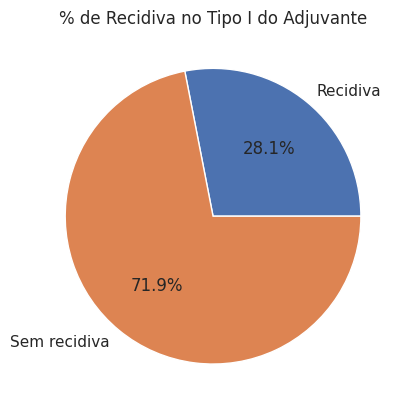

In [ ]:
# Transforma os 1s e 0s em booleanos
df_explorando_recidiva['Terapia Neoadjuvante'] = df_explorando_recidiva['Terapia Neoadjuvante'].astype(bool)
df_explorando_recidiva['Terapia Adjuvante'] = df_explorando_recidiva['Terapia Adjuvante'].astype(bool)
# Filtra o df
df_filtered = df_explorando_recidiva[df_explorando_recidiva['Terapia Neoadjuvante'] & (df_explorando_recidiva['subtipo_tumoral'] == 2) & (df_explorando_recidiva['idade_primeiro_diagnostico'] > 0)]

# Calculando a porcentagem de True e False na coluna 'sim'
total = len(df_filtered)
percent_true = (df_filtered['Sim'] == 1).sum() / total * 100
percent_false = (df_filtered['Sim'] == 0).sum() / total * 100

# Gerando o gráfico de pizza com as porcentagens de True e False
plt.pie([percent_true, percent_false], labels=['Recidiva', 'Sem recidiva'], autopct='%1.1f%%')
plt.title('% de Recidiva no Tipo I do Adjuvante')
plt.show()

# Neoadjuvante: % de recidiva por subtipo tumoral acima de 50 anos: 1= 45%, 2= 23,3%, 3= 26,7% e 4=29,2%
# Adjuvante: % de recidiva por subtipo tumoral: 1= 1,9%, 2=10%, 3= 15% e 4=14%


In [ ]:
print(df_explorando_recidiva.columns)

Index(['record_id', 'estadio_clinico', 'classificacao_tnm_clinico_t',
       'classificacao_tnm_clinico_n', 'classificacao_tnm_clinico_m',
       'tempo_desde_o_diagnostico_ate_a_primeira_recidiva', 'recidiva', 'imc',
       'subtipo_tumoral', 'receptor_de_estrogenio', 'estrogenio_qtd',
       'receptor_de_progesterona', 'progesterona_qtd', 'ki67_14', 'ki67_qtd',
       'her2_por_ihc', 'atividade_fisica', 'regime_de_tratamento',
       'idade_primeiro_diagnostico', 'sobrevida',
       'ultima_informacao_do_paciente', 'Terapia Adjuvante',
       'Terapia Neoadjuvante', 'Não', 'Sim'],
      dtype='object')


[ True False]
[False  True]
[2. 4. 3. 1.]


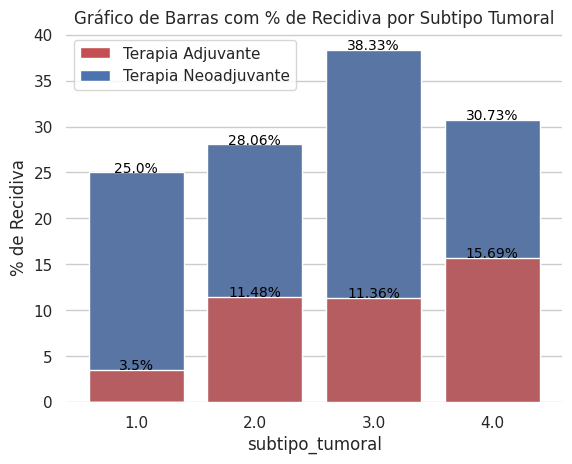

In [ ]:
df_explorando_recidiva['subtipo_tumoral'] = df_explorando_recidiva['subtipo_tumoral'].replace(5, 4)

print(df_explorando_recidiva['Terapia Adjuvante'].unique())
print(df_explorando_recidiva['Terapia Neoadjuvante'].unique())
print(df_explorando_recidiva['subtipo_tumoral'].unique())

df_filtered = df_explorando_recidiva

grouped = df_filtered.groupby('subtipo_tumoral')

# Calculando a porcentagem de valores True na coluna 'Sim', para as condições 'Terapia Neoadjuvante' e 'Terapia Adjuvante', em cada grupo da coluna 'subtipo_tumoral'
percent_true_neo = grouped.apply(lambda x: (x['Sim'][x['Terapia Neoadjuvante'] == True].sum() / len(x[x['Terapia Neoadjuvante'] == True])) * 100)
percent_true_adj = grouped.apply(lambda x: (x['Sim'][x['Terapia Adjuvante'] == True].sum() / len(x[x['Terapia Adjuvante'] == True])) * 100)

# Criando um DataFrame com as informações calculadas acima
df_plot = pd.DataFrame({'Terapia Neoadjuvante': percent_true_neo, 'Terapia Adjuvante': percent_true_adj})
df_plot = df_plot.reset_index()

colors = {"Terapia Adjuvante": "r", "Terapia Neoadjuvante": "b"}

# Plotando o gráfico
sns.set(style="whitegrid")
ax = sns.barplot(x="subtipo_tumoral", y="Terapia Neoadjuvante", data=df_plot, color="b")
ax = sns.barplot(x="subtipo_tumoral", y="Terapia Adjuvante", data=df_plot, color="r")
ax.set(ylabel="% de Recidiva", title="Gráfico de Barras com % de Recidiva por Subtipo Tumoral")
sns.despine(left=True, bottom=True)

for t in colors:
    ax.bar(0, 0, color=colors[t], label=t)
ax.legend()

# Adicionando as anotações com as porcentagens no meio de cada coluna
for i in range(len(df_plot)):
    ax.annotate(str(round(df_plot.iloc[i]['Terapia Neoadjuvante'], 2)) + "%", xy=(i, df_plot.iloc[i]['Terapia Neoadjuvante']), fontsize=10, color='black', ha='center', va='baseline')
    ax.annotate(str(round(df_plot.iloc[i]['Terapia Adjuvante'], 2)) + "%", xy=(i, df_plot.iloc[i]['Terapia Adjuvante']), fontsize=10, color='black', ha='center', va='baseline')

plt.show()



### Corrigindo target

In [ ]:
# cria uma cópia do DataFrame original
dfteste = df.copy()

# remove casos de fracasso que contêm a string "Obito por câncer" na coluna "ultima_informacao_do_paciente"
dfteste = dfteste.query('ultima_informacao_do_paciente != "Obito por câncer"')

# cria uma nova coluna "grupo_de_idade" que armazena o grupo de idade (10 anos de intervalo) de cada paciente
dfteste['grupo_de_idade'] = dfteste['idade_primeiro_diagnostico'].apply(lambda x: int(x/10))

# itera sobre cada grupo de idade e subtipo tumoral
for grupo_idade in dfteste['grupo_de_idade'].unique():
  for subtipo_tumoral in dfteste['subtipo_tumoral'].unique():
    # calcula o primeiro quartil dos tempos desde o diagnóstico até a primeira recidiva para o grupo de idade e subtipo tumoral atual
    # e armazena o valor em "primeiro_quartil"
    primeiro_quartil = dfteste.query('tempo_desde_o_diagnostico_ate_a_primeira_recidiva > 0 & grupo_de_idade == ' + str(grupo_idade) + ' & subtipo_tumoral == ' + str(subtipo_tumoral))['tempo_desde_o_diagnostico_ate_a_primeira_recidiva'].quantile(0.10)
    # verifica se "primeiro_quartil" não é NaN
    if not np.isnan(primeiro_quartil):
      # seleciona os pacientes que estão no grupo de idade e subtipo tumoral atual e que tiveram uma recidiva depois do primeiro quartil de tempo
      pacientes_fracasso = dfteste.query('tempo_desde_o_diagnostico_ate_a_primeira_recidiva > 0 & tempo_desde_o_diagnostico_ate_a_primeira_recidiva > ' + str(primeiro_quartil) + ' & grupo_de_idade == ' + str(grupo_idade) + ' & subtipo_tumoral ==' + str(subtipo_tumoral))
      # remove os pacientes selecionados do DataFrame
      dfteste = dfteste.drop(pacientes_fracasso.index)

# atualiza o DataFrame original com o DataFrame modificado
df = dfteste


In [ ]:
print(df['record_id'].count())
px.bar(df['regime_de_tratamento'].value_counts())

1554


In [ ]:
# remove colunas
df = df.drop(columns=['recidiva', 'sobrevida', 'grupo_de_idade', 'tempo_desde_o_diagnostico_ate_a_primeira_recidiva'])
df = df.drop(columns=['ultima_informacao_do_paciente'])

# Normalização

## Divisão de colunas Categóricas e Numéricas

In [ ]:
df['atividade_fisica'].unique()

array([nan, 'Pratica esporadicamente', 'Não pratica',
       'Pratica regularmente', 'Pratica frequentemente'], dtype=object)

In [ ]:
df['receptor_de_estrogenio'].unique()

array(['negativo', 'positivo'], dtype=object)

In [ ]:
df['receptor_de_progesterona'].unique()

array(['negativo', 'positivo'], dtype=object)

In [ ]:
df['ki67_14'].unique()

array(['positivo', 'negativo'], dtype=object)

In [ ]:
df['her2_por_ihc'].unique()

array([' +++ (positivo)', '0 (negativo)', ' + (negativo)',
       ' ++ (duvidoso)', 'indeterminado'], dtype=object)

In [ ]:
df['estadio_clinico'].unique()

array(['IIIA', 'IIB', 'IIA', 'I', 'IIIB', 'IIIC', '0', 'IV', 'IA', 'IB'],
      dtype=object)

In [ ]:
df.columns

Index(['record_id', 'estadio_clinico', 'classificacao_tnm_clinico_t',
       'classificacao_tnm_clinico_n', 'classificacao_tnm_clinico_m', 'imc',
       'subtipo_tumoral', 'receptor_de_estrogenio', 'estrogenio_qtd',
       'receptor_de_progesterona', 'progesterona_qtd', 'ki67_14', 'ki67_qtd',
       'her2_por_ihc', 'atividade_fisica', 'regime_de_tratamento',
       'idade_primeiro_diagnostico'],
      dtype='object')

In [ ]:
df['her2_por_ihc'].unique()

array([' +++ (positivo)', '0 (negativo)', ' + (negativo)',
       ' ++ (duvidoso)', 'indeterminado'], dtype=object)

In [ ]:
# cria uma lista de colunas numéricas a serem selecionadas
colunas_numericas = ['imc', 'estrogenio_qtd', 'progesterona_qtd', 'ki67_qtd', 'idade_primeiro_diagnostico']
# cria um novo DataFrame com apenas as colunas numéricas especificadas
df_numericas = df[colunas_numericas]
# cria um novo DataFrame com todas as colunas exceto as colunas numéricas e a coluna 'record_id'
df_categoricas = df.drop(columns=[*colunas_numericas, 'record_id'])


## Categóricas

In [ ]:
value_counts_buffado(df_categoricas)


estadio_clinico

       count  percentage
IIA     438   28.185328
IIB     378   24.324324
IIIA    334   21.492921
IIIB    146    9.395109
IA      113    7.271557
I        61    3.925354
IIIC     48    3.088803
IB       18    1.158301
IV       15    0.965251
0         3    0.193050

classificacao_tnm_clinico_t

     count  percentage
2     749   48.198198
3     330   21.235521
1     311   20.012870
4     161   10.360360
IS      3    0.193050

classificacao_tnm_clinico_n

    count  percentage
0    658   42.342342
1    613   39.446589
2    229   14.736165
3     54    3.474903

classificacao_tnm_clinico_m

    count  percentage
0   1539   99.034749
1     15    0.965251

subtipo_tumoral

      count  percentage
2.0    548   35.263835
4.0    403   25.933076
5.0    345   22.200772
1.0    151    9.716860
3.0    107    6.885457

receptor_de_estrogenio

           count  percentage
positivo   1033   66.473616
negativo    521   33.526384

receptor_de_progesterona

           count  percentage
p

### Label Encode

In [ ]:
# exibe a contagem de valores de cada coluna do DataFrame `df_categoricas`
value_counts_buffado(df_categoricas)

# transforma os valores das colunas categóricas em numéricos
df_categoricas['classificacao_tnm_clinico_t'] = df_categoricas['classificacao_tnm_clinico_t'].replace({
    'IS': 0
}).astype(int)

df_categoricas['receptor_de_estrogenio'] = df_categoricas['receptor_de_estrogenio'].replace({
    'negativo': 0,
    'positivo': 1
}).astype(int)

df_categoricas['receptor_de_progesterona'] = df_categoricas['receptor_de_progesterona'].replace({
    'negativo': 0,
    'positivo': 1
}).astype(int)

df_categoricas['ki67_14'] = df_categoricas['ki67_14'].replace({
    'negativo': 0,
    'positivo': 1
}).astype(int)

df_categoricas['classificacao_tnm_clinico_n'] = df_categoricas['classificacao_tnm_clinico_n'].astype(int)

df_categoricas['classificacao_tnm_clinico_m'] = df_categoricas['classificacao_tnm_clinico_m'].astype(int)

df_categoricas['subtipo_tumoral'] = df_categoricas['subtipo_tumoral'].astype(int)

df_categoricas['regime_de_tratamento'] = df_categoricas['regime_de_tratamento'].replace({
    'Terapia Adjuvante': 0,
    'Terapia Neoadjuvante': 1
}).astype(int)

# preenche com zero os valores nulos da coluna `atividade_fisica`
df_categoricas.loc[df_categoricas['atividade_fisica'].isna(), 'atividade_fisica'] = 0
# transforma os valores da coluna `atividade_fisica`
df_categoricas['atividade_fisica'] = df_categoricas['atividade_fisica'].replace({
    'Não pratica': -1,
    'Pratica esporadicamente': 1,
    'Pratica regularmente': 2,
    'Pratica frequentemente': 3
}).astype(int)

# exibe a contagem de valores de cada coluna do DataFrame `df_categoricas` após as transformações
value_counts_buffado(df_categoricas)



estadio_clinico

       count  percentage
IIA     438   28.185328
IIB     378   24.324324
IIIA    334   21.492921
IIIB    146    9.395109
IA      113    7.271557
I        61    3.925354
IIIC     48    3.088803
IB       18    1.158301
IV       15    0.965251
0         3    0.193050

classificacao_tnm_clinico_t

     count  percentage
2     749   48.198198
3     330   21.235521
1     311   20.012870
4     161   10.360360
IS      3    0.193050

classificacao_tnm_clinico_n

    count  percentage
0    658   42.342342
1    613   39.446589
2    229   14.736165
3     54    3.474903

classificacao_tnm_clinico_m

    count  percentage
0   1539   99.034749
1     15    0.965251

subtipo_tumoral

      count  percentage
2.0    548   35.263835
4.0    403   25.933076
5.0    345   22.200772
1.0    151    9.716860
3.0    107    6.885457

receptor_de_estrogenio

           count  percentage
positivo   1033   66.473616
negativo    521   33.526384

receptor_de_progesterona

           count  percentage
p

### One Hot Encode

In [ ]:
df_categoricas = pd.concat([df_categoricas, pd.get_dummies(df_categoricas['estadio_clinico'], prefix='est_c_')], axis=1)
df_categoricas = pd.concat([df_categoricas, pd.get_dummies(df_categoricas['her2_por_ihc'], prefix='her2_')], axis=1)


# Removendo colunas desnecessárias
df_categoricas = normalize_columns_name(df_categoricas).drop(columns=['estadio_clinico', 'her2_por_ihc'])

value_counts_buffado(df_categoricas)


classificacao_tnm_clinico_t

    count  percentage
2    749   48.198198
3    330   21.235521
1    311   20.012870
4    161   10.360360
0      3    0.193050

classificacao_tnm_clinico_n

    count  percentage
0    658   42.342342
1    613   39.446589
2    229   14.736165
3     54    3.474903

classificacao_tnm_clinico_m

    count  percentage
0   1539   99.034749
1     15    0.965251

subtipo_tumoral

    count  percentage
2    548   35.263835
4    403   25.933076
5    345   22.200772
1    151    9.716860
3    107    6.885457

receptor_de_estrogenio

    count  percentage
1   1033   66.473616
0    521   33.526384

receptor_de_progesterona

    count  percentage
1    890   57.271557
0    664   42.728443

ki67_14

    count  percentage
1   1369   88.095238
0    185   11.904762

atividade_fisica

     count  percentage
 0   1419   91.312741
-1    100    6.435006
 2     22    1.415701
 1      8    0.514801
 3      5    0.321750

regime_de_tratamento

    count  percentage
0    911   58.622

In [ ]:
# Merge categóricas e numéricas
df = pd.concat([df_categoricas, df_numericas], axis=1)

## Separando target de features

In [ ]:
# definindo x e y para separar em treino e teste
df_x = df.drop(columns=['regime_de_tratamento'])
df_y = df['regime_de_tratamento']

## Separação dos conjuntos de treino e teste

In [ ]:
# separando em dados de treino e dados de teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 1)
X_train

,classificacao_tnm_clinico_t,classificacao_tnm_clinico_n,classificacao_tnm_clinico_m,subtipo_tumoral,receptor_de_estrogenio,receptor_de_progesterona,ki67_14,atividade_fisica,est_c_0,est_c_i,...,her2_+_negativo,her2_++_duvidoso,her2_+++_positivo,her2_0_negativo,her2_indeterminado,imc,estrogenio_qtd,progesterona_qtd,ki67_qtd,idade_primeiro_diagnostico
1326,2,1,0,1,1,1,0,-1,0,0,...,0,0,0,1,0,25.402816,100.0,90.0,5.000000,54.0
1402,2,0,0,2,1,1,1,0,0,0,...,0,0,0,1,0,43.038502,90.0,80.0,40.000000,48.0
622,3,0,0,2,1,1,1,0,0,0,...,0,0,0,1,0,22.279036,1.0,1.0,25.000000,55.0
1277,2,0,0,5,1,0,1,0,0,0,...,0,0,1,0,0,21.989892,90.0,0.0,33.094286,46.0
692,3,2,0,4,0,0,1,0,0,0,...,0,0,0,1,0,19.531250,0.0,0.0,80.000000,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,4,0,0,5,1,1,1,0,0,0,...,0,0,1,0,0,34.207486,100.0,100.0,40.000000,42.0
1258,2,2,0,5,0,1,1,0,0,0,...,0,0,1,0,0,26.260078,0.0,20.0,49.310345,73.0
1524,1,1,0,1,1,1,0,0,0,0,...,0,0,0,1,0,32.629936,90.0,30.0,10.000000,63.0
373,4,2,0,4,0,0,1,-1,0,0,...,0,0,0,1,0,36.649821,0.0,0.0,80.000000,33.0


In [ ]:
X_train.columns

Index(['classificacao_tnm_clinico_t', 'classificacao_tnm_clinico_n',
       'classificacao_tnm_clinico_m', 'subtipo_tumoral',
       'receptor_de_estrogenio', 'receptor_de_progesterona', 'ki67_14',
       'atividade_fisica', 'est_c_0', 'est_c_i', 'est_c_ia', 'est_c_ib',
       'est_c_iia', 'est_c_iib', 'est_c_iiia', 'est_c_iiib', 'est_c_iiic',
       'est_c_iv', 'her2_+_negativo', 'her2_++_duvidoso', 'her2_+++_positivo',
       'her2_0_negativo', 'her2_indeterminado', 'imc', 'estrogenio_qtd',
       'progesterona_qtd', 'ki67_qtd', 'idade_primeiro_diagnostico'],
      dtype='object')

## Lidando com Desbalanceamento de Classes

In [ ]:
from imblearn.under_sampling import OneSidedSelection

# Undersampling -> OneSidedSelection -> Junção de linhas da classe majoritária pela proximidade (tipo KNN)
oss = OneSidedSelection(random_state = 1)
X_train, y_train = oss.fit_resample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler

# Oversampling -> RandomOverSampler -> Pega amostras aleatórias da classe minoritária e as duplica para aumentar sua quantidade
ros = RandomOverSampler(random_state=1)
X_train, y_train = ros.fit_resample(X_train, y_train)

px.bar(y_train.value_counts())

In [ ]:
# normalizando dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train[colunas_numericas] = scaler.fit_transform(X_train[colunas_numericas])

from joblib import dump

dump(scaler, 'minMax.scaler')

X_test[colunas_numericas] = scaler.transform(X_test[colunas_numericas])

X_train[colunas_numericas]

,imc,estrogenio_qtd,progesterona_qtd,ki67_qtd,idade_primeiro_diagnostico
0,0.215270,0.01,0.00,0.193548,0.138462
1,0.157767,1.00,0.00,0.301075,0.553846
2,0.339949,0.90,0.90,0.247312,0.415385
3,0.167147,0.70,0.70,0.301075,0.169231
4,0.264327,0.95,0.00,0.139785,0.630769
...,...,...,...,...,...
1211,0.245677,0.00,0.00,0.354839,0.600000
1212,0.078430,0.00,0.00,0.193548,0.353846
1213,0.247481,0.90,0.90,0.032258,0.153846
1214,0.183203,1.00,0.20,0.408602,0.184615


# Modelos

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import shap

def print_results(model, X_train, y_train, X_test, y_test):
  y_pred = model.predict(X_test)

  print("Acurácia Treino: " + str(model.score(X_train, y_train)))
  print("Acurácia Teste: " + str(model.score(X_test, y_test)))
  print("F1: " + str(f1_score(y_test, y_pred)))
  print("Recall Teste: " + str(recall_score(y_test, y_pred)))
  print("Precisao Teste: " + str(precision_score(y_test, y_pred)))

  labels = ['Terapia Adjuvante', 'Terapia Neoadjuvante']
  
  px.imshow(confusion_matrix(y_test, y_pred, labels=[0, 1]), text_auto=True, aspect="auto", labels=dict(x="Valores Preditos", y="Valores Reais", color="Intensidade"), x=labels, y=labels).show()

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# função para pegar o melhor numero de vizinhos para o KNN
def get_best_n_neighbors(X_train, y_train, X_test, y_test, max = 103, printValues=False):
  if max % 2 == 0:
    max+=-1
  
  max_acc = 0
  best_knn = 0

  for i in range(3, max+1, 2):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(X_train, y_train)
    score = knn_classifier.score(X_test, y_test)

    if printValues:
      print('k: ' + str(i) + '\nScore: ' + str(score) + '\n\n')

    if(max_acc < score):
      max_acc = score
      best_knn = knn_classifier

  return best_knn

print(X_train.dtypes)
print(y_train.dtypes)

classificacao_tnm_clinico_t      int64
classificacao_tnm_clinico_n      int64
classificacao_tnm_clinico_m      int64
subtipo_tumoral                  int64
receptor_de_estrogenio           int64
receptor_de_progesterona         int64
ki67_14                          int64
atividade_fisica                 int64
est_c_0                          uint8
est_c_i                          uint8
est_c_ia                         uint8
est_c_ib                         uint8
est_c_iia                        uint8
est_c_iib                        uint8
est_c_iiia                       uint8
est_c_iiib                       uint8
est_c_iiic                       uint8
est_c_iv                         uint8
her2_+_negativo                  uint8
her2_++_duvidoso                 uint8
her2_+++_positivo                uint8
her2_0_negativo                  uint8
her2_indeterminado               uint8
imc                            float64
estrogenio_qtd                 float64
progesterona_qtd         

In [ ]:
knn_classifier = get_best_n_neighbors(X_train, y_train, X_test, y_test)
print("Ideal K: " + str(knn_classifier.n_neighbors))
print_results(knn_classifier, X_train, y_train, X_test, y_test)

Ideal K: 5
Acurácia Treino: 0.8248355263157895
Acurácia Teste: 0.7556270096463023
F1: 0.7205882352941176
Recall Teste: 0.765625
Precisao Teste: 0.6805555555555556


## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# funcao para pegar os melhores parametros para o Random Forest
def get_best_prune(X_train, y_train, X_test, y_test, min = 1, max = 10, n_estimators = 100, random_state = 1, printValues=False):
  max_acc = 0
  best_rf = 0

  for i in range(min, max+1, 1):
    rf_classifier = RandomForestClassifier(random_state=random_state, max_depth = i, n_estimators=n_estimators)
    rf_classifier.fit(X_train, y_train)
    
    score = rf_classifier.score(X_test, y_test)

    if printValues:
      print('max_prune: ' + str(i) + '\nScore teste:' + str(rf_classifier.score(X_train, y_train)) + '\nScore: ' + str(score) + '\n\n')

    if(max_acc < score):
      max_acc = score
      best_rf = rf_classifier

  return best_rf
# funcao para mostras as colunas de maior importancia para o modelo
def show_rf_columns_importance(rf_classifier, x):
  importances = rf_classifier.feature_importances_
  feature_names = x.columns
  df_i = pd.DataFrame({
      'coluna': feature_names,
      'importancia': importances
  }).sort_values('importancia')

  
  explainer = shap.TreeExplainer(rf_classifier)
  shap_values = explainer.shap_values(x)
  shap.summary_plot(shap_values, x)

  return px.bar(x=df_i['coluna'], y=df_i['importancia'], title='Colunas mais relevantes').show()

  

Melhor prune: 14


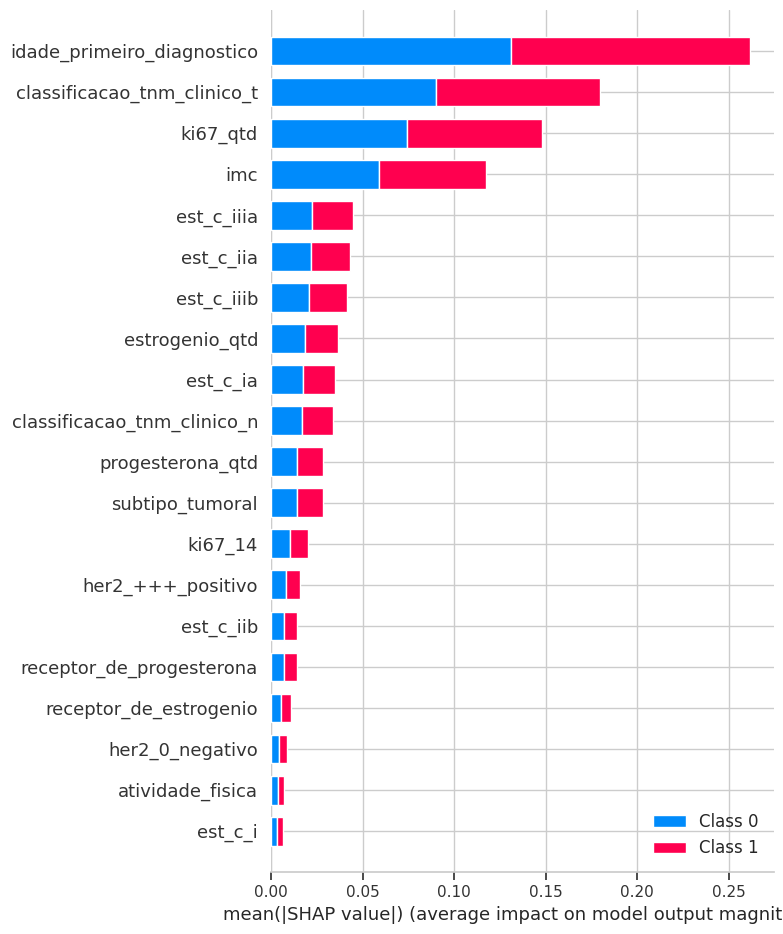

Acurácia Treino: 0.9925986842105263
Acurácia Teste: 0.7781350482315113
F1: 0.739622641509434
Recall Teste: 0.765625
Precisao Teste: 0.7153284671532847


In [ ]:
rf_classifier = get_best_prune(X_train, y_train, X_test, y_test, 12, 17, 70, 1)
print('Melhor prune: ' + str(rf_classifier.max_depth))
show_rf_columns_importance(rf_classifier, df_x)
print_results(rf_classifier, X_train, y_train, X_test, y_test)

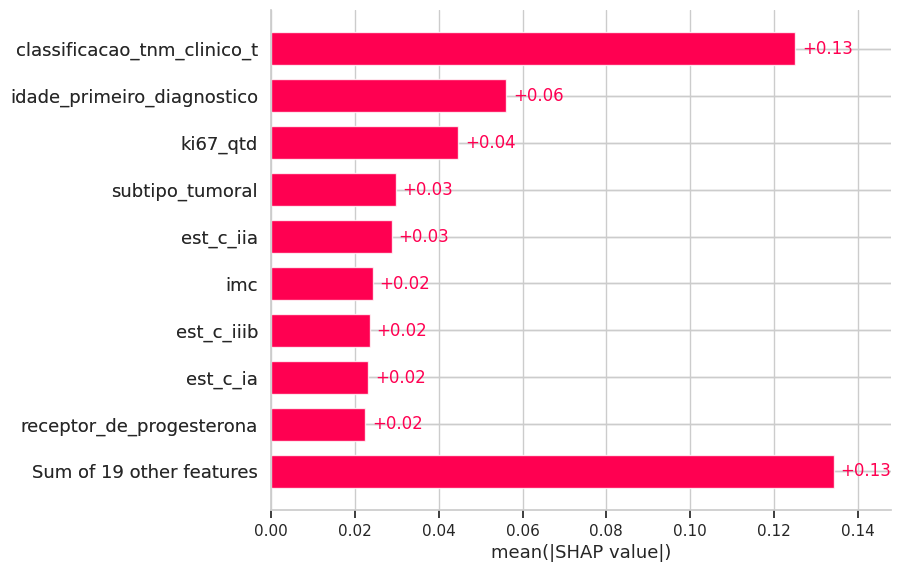

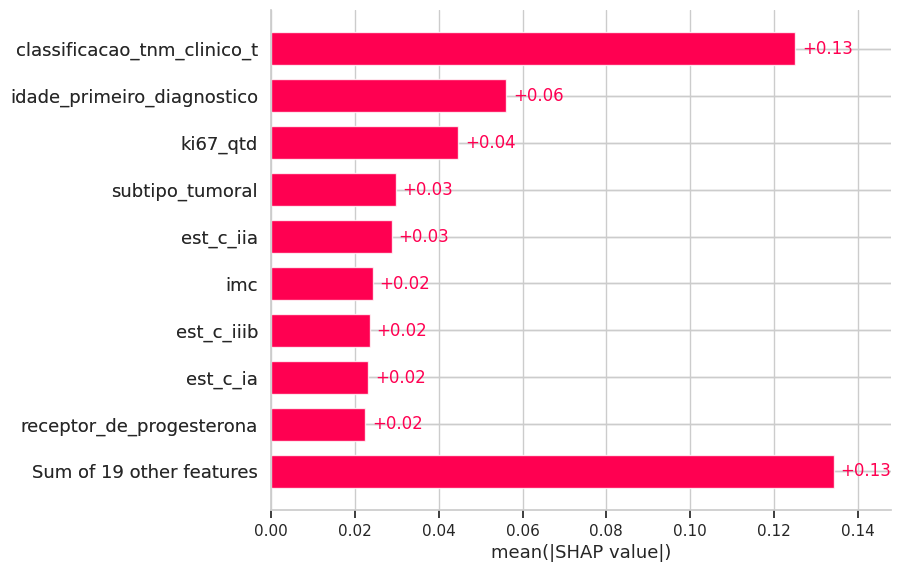

In [ ]:
explainer = shap.Explainer(rf_classifier)
shap_test = explainer(X_test)
shap.plots.bar(shap_test[:,:,1])
shap.plots.bar(shap_test[:,:,0])

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

print_results(gnb_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.6299342105263158
Acurácia Teste: 0.5787781350482315
F1: 0.6579634464751959
Recall Teste: 0.984375
Precisao Teste: 0.49411764705882355


## SVM

In [ ]:
from sklearn.svm import SVC

csv_classifier = SVC(kernel='linear')
csv_classifier.fit(X_train, y_train)

print_results(csv_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.7919407894736842
Acurácia Teste: 0.7684887459807074
F1: 0.7272727272727272
Recall Teste: 0.75
Precisao Teste: 0.7058823529411765


## ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ab_classifier = AdaBoostClassifier()
ab_classifier.fit(X_train, y_train)

print_results(ab_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.8125
Acurácia Teste: 0.7717041800643086
F1: 0.73992673992674
Recall Teste: 0.7890625
Precisao Teste: 0.696551724137931


# Análises

## Modelos

In [ ]:
px.imshow(df.corr(), text_auto=True, aspect="auto", color_continuous_scale='RdBu').show()

## Tabelas

### Demográficos

### Histopatologia

In [ ]:
px.box(df[['subtipo_tumoral', 'ki67_qtd', 'progesterona_qtd', 'estrogenio_qtd']], color='subtipo_tumoral')

### Peso e Altura

### Tumores

In [ ]:
df_x.head()

,classificacao_tnm_clinico_t,classificacao_tnm_clinico_n,classificacao_tnm_clinico_m,subtipo_tumoral,receptor_de_estrogenio,receptor_de_progesterona,ki67_14,atividade_fisica,est_c_0,est_c_i,...,her2_+_negativo,her2_++_duvidoso,her2_+++_positivo,her2_0_negativo,her2_indeterminado,imc,estrogenio_qtd,progesterona_qtd,ki67_qtd,idade_primeiro_diagnostico
2,3,2,0,3,0,0,1,0,0,0,...,0,0,1,0,0,33.046031,0.0,0.0,55.257194,29.0
3,2,1,0,2,1,1,1,0,0,0,...,0,0,0,1,0,32.000000,1.0,1.0,85.000000,39.0
5,3,1,0,4,0,0,1,0,0,0,...,0,0,0,1,0,36.958451,0.0,0.0,80.000000,29.0
7,2,1,0,3,0,0,1,0,0,0,...,0,0,1,0,0,29.530559,90.0,0.0,50.000000,50.0
11,2,0,0,4,0,0,1,0,0,0,...,0,0,0,1,0,27.434842,0.0,0.0,15.000000,65.0


In [ ]:
X_train.head()

,classificacao_tnm_clinico_t,classificacao_tnm_clinico_n,classificacao_tnm_clinico_m,subtipo_tumoral,receptor_de_estrogenio,receptor_de_progesterona,ki67_14,atividade_fisica,est_c_0,est_c_i,...,her2_+_negativo,her2_++_duvidoso,her2_+++_positivo,her2_0_negativo,her2_indeterminado,imc,estrogenio_qtd,progesterona_qtd,ki67_qtd,idade_primeiro_diagnostico
0,2,0,0,5,1,0,1,0,0,0,...,0,0,1,0,0,0.215270,0.01,0.0,0.193548,0.138462
1,2,1,0,2,1,0,1,0,0,0,...,0,0,0,1,0,0.157767,1.00,0.0,0.301075,0.553846
2,1,0,0,2,1,1,1,0,0,0,...,0,0,0,1,0,0.339949,0.90,0.9,0.247312,0.415385
3,2,2,0,2,1,1,1,0,0,0,...,0,0,0,1,0,0.167147,0.70,0.7,0.301075,0.169231
4,2,1,0,2,1,0,1,0,0,0,...,0,0,0,1,0,0.264327,0.95,0.0,0.139785,0.630769


In [ ]:
X_train.columns

Index(['classificacao_tnm_clinico_t', 'classificacao_tnm_clinico_n',
       'classificacao_tnm_clinico_m', 'subtipo_tumoral',
       'receptor_de_estrogenio', 'receptor_de_progesterona', 'ki67_14',
       'atividade_fisica', 'est_c_0', 'est_c_i', 'est_c_ia', 'est_c_ib',
       'est_c_iia', 'est_c_iib', 'est_c_iiia', 'est_c_iiib', 'est_c_iiic',
       'est_c_iv', 'her2_+_negativo', 'her2_++_duvidoso', 'her2_+++_positivo',
       'her2_0_negativo', 'her2_indeterminado', 'imc', 'estrogenio_qtd',
       'progesterona_qtd', 'ki67_qtd', 'idade_primeiro_diagnostico'],
      dtype='object')

In [ ]:
df_y.value_counts()

0    911
1    643
Name: regime_de_tratamento, dtype: int64

# Hiperparâmetros

##KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define o escopo dos parâmetros
dicionario_grid_knn = {'n_neighbors':np.arange(3, 300, 2),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'chebyshev'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Define o algoritmo
knn = KNeighborsClassifier()

# Executa a pesquisa pelos melhores parâmetros
random_search_knn = RandomizedSearchCV(knn, dicionario_grid_knn, cv=5, random_state=777)
random_search_knn.fit(X_train, y_train)

# Exibe os melhores parâmetros e a pontuação correspondente
print("Melhores parâmetros: ", random_search_knn.best_params_)
print("Melhor pontuação: ", random_search_knn.best_score_)


Melhores parâmetros:  {'weights': 'distance', 'n_neighbors': 129, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Melhor pontuação:  0.7870437833097214


Testando os parâmetros no conjunto de teste

In [ ]:
knn_classifier = random_search_knn.best_estimator_
print_results(knn_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 1.0
Acurácia Teste: 0.7588424437299035
F1: 0.7211895910780669
Recall Teste: 0.7578125
Precisao Teste: 0.6879432624113475


## RANDOM FOREST

In [ ]:
rf = RandomForestClassifier(random_state=777, min_samples_split=20)

# Define o escopo dos hiperparâmetros
dicionario_grid_rf = {
    'n_estimators': np.arange(1, 300, 1),
    'max_features': np.arange(1, 5, 1)
}

# Treina o random search para encontrar os melhores parâmetros
random_search_rf = RandomizedSearchCV(rf, dicionario_grid_rf, cv=5)
random_search_rf.fit(X_train, y_train)

# Exibe os melhores parâmetros e a melhor acurácia
print("Melhores parâmetros: ", random_search_rf.best_params_)
print("Melhor acurácia: ", random_search_rf.best_score_)


Melhores parâmetros:  {'n_estimators': 246, 'max_features': 3}
Melhor acurácia:  0.787033663900695


Testando os parâmetros no conjunto de teste

In [ ]:
rf_classifier = random_search_rf.best_estimator_
print_results(rf_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.8667763157894737
Acurácia Teste: 0.7813504823151125
F1: 0.744360902255639
Recall Teste: 0.7734375
Precisao Teste: 0.717391304347826


## NAIVE BAYES

In [ ]:
from sklearn.model_selection import GridSearchCV

nb = GaussianNB()

# Define o escopo dos parâmetros
dicionario_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
}

# Treina o Grid Search para encontrar os melhores parâmetros
grid_search_nb = GridSearchCV(estimator=nb, param_grid=dicionario_nb, cv=5)
grid_search_nb.fit(X_train, y_train)

# Exibe o melhor conjunto de hiperparâmetros encontrado
print("Melhores hiperparâmetros:", grid_search_nb.best_params_)
print("Melhor acurácia:", grid_search_nb.best_score_)

Melhores hiperparâmetros: {'var_smoothing': 1}
Melhor acurácia: 0.7450718478040883


Exibindo as métricas

In [ ]:
nb_classifier = grid_search_nb.best_estimator_
print_results(nb_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.7458881578947368
Acurácia Teste: 0.7427652733118971
F1: 0.7142857142857143
Recall Teste: 0.78125
Precisao Teste: 0.6578947368421053


## SVM

In [ ]:
from scipy import stats

svm = SVC(random_state=777)

# Define o escopo dos parâmetros a serem testados
dicionario_svm = {
    'C': np.arange(0.1, 1, 0.1),
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

# Treina o random search
random_search_svm = RandomizedSearchCV(svm, dicionario_svm, cv=5)
random_search_svm.fit(X_train, y_train)

# Exibe o melhor conjunto de hiperparâmetros encontrado
print("Melhores hiperparâmetros:", random_search_svm.best_params_)
print("Melhor acurácia:", random_search_svm.best_score_)

Melhores hiperparâmetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.6}
Melhor acurácia: 0.7845510355528571


Testando os parâmetros no conjunto de teste

In [ ]:
#svm_classifier = random_search_svm.best_estimator_
svm_classifier = random_search_svm.best_estimator_
print_results(svm_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.790296052631579
Acurácia Teste: 0.7717041800643086
F1: 0.7320754716981134
Recall Teste: 0.7578125
Precisao Teste: 0.708029197080292


## ADABOOST

In [ ]:
ab = AdaBoostClassifier(random_state=777)
# Define de parâmetros a serem testados
dicionario_ab = {
    'n_estimators': np.arange(10, 200, 10),
    'learning_rate': [0.1, 2.0, 0.2],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Cria um objeto RandomizedSearchCV para encontrar os melhores parâmetros
random_search_ab = RandomizedSearchCV(ab, dicionario_ab, cv=5)

# Treina o modelo com a busca randomizada
random_search_ab.fit(X_train, y_train)

# Mostra os melhores parâmetros e melhor acurácia encontrados
print("Melhores parâmetros: ", random_search_ab.best_params_)
print("Melhor acurácia: ", random_search_ab.best_score_)


Melhores parâmetros:  {'n_estimators': 50, 'learning_rate': 0.2, 'algorithm': 'SAMME.R'}
Melhor acurácia:  0.7829049450178777


Testa os parâmetros no conjunto de teste

In [ ]:
ab_classifier = random_search_ab.best_estimator_
print_results(ab_classifier, X_train, y_train, X_test, y_test)

Acurácia Treino: 0.7976973684210527
Acurácia Teste: 0.7781350482315113
F1: 0.739622641509434
Recall Teste: 0.765625
Precisao Teste: 0.7153284671532847


In [ ]:
rf_classifier.fit(df_x, df_y)

dump(rf_classifier, 'modelo_rf_classifier.model')

['modelo_rf_classifier.model']

In [ ]:
df_x.columns

Index(['classificacao_tnm_clinico_t', 'classificacao_tnm_clinico_n',
       'classificacao_tnm_clinico_m', 'subtipo_tumoral',
       'receptor_de_estrogenio', 'receptor_de_progesterona', 'ki67_14',
       'atividade_fisica', 'est_c_0', 'est_c_i', 'est_c_ia', 'est_c_ib',
       'est_c_iia', 'est_c_iib', 'est_c_iiia', 'est_c_iiib', 'est_c_iiic',
       'est_c_iv', 'her2_+_negativo', 'her2_++_duvidoso', 'her2_+++_positivo',
       'her2_0_negativo', 'her2_indeterminado', 'imc', 'estrogenio_qtd',
       'progesterona_qtd', 'ki67_qtd', 'idade_primeiro_diagnostico'],
      dtype='object')

In [ ]:
"""from google.colab import files
X_test.to_csv('X_test.csv', encoding = 'utf-8-sig', index=False) 
files.download('X_test.csv')"""

"from google.colab import files\nX_test.to_csv('X_test.csv', encoding = 'utf-8-sig', index=False) \nfiles.download('X_test.csv')"

# Predição

In [ ]:
"""# Importa as bibliotecas necessárias
from google.colab import files
import io
# Recebe os dados
upload = files.upload()
# Pega os dados de dentro do arquivo
dados = list(upload.values())[0]
# Deixa os dados em um formato legível para o pandas
dados_legiveis = io.BytesIO(dados)
# Transforma os dados em dataframe
dados_df = pd.read_csv(dados_legiveis)
# Realiza as predições
predicoes = rf_classifier.predict(dados_df)
# Troca as predições de 0 e 1 para strings
predicoes_em_string = np.where(predicoes == 1, 'neoadjuvante', 'adjuvante')
# Adiciona as predições ao dataframe
dados_df['regime_recomendado'] = predicoes_em_string
# Transforma os dados de volta em csv
dados_df.to_csv('predicoes.csv', encoding = 'utf-8-sig', index=False)
# Realiza o download dos dados com as predições
files.download('predicoes.csv')"""

"# Importa as bibliotecas necessárias\nfrom google.colab import files\nimport io\n# Recebe os dados\nupload = files.upload()\n# Pega os dados de dentro do arquivo\ndados = list(upload.values())[0]\n# Deixa os dados em um formato legível para o pandas\ndados_legiveis = io.BytesIO(dados)\n# Transforma os dados em dataframe\ndados_df = pd.read_csv(dados_legiveis)\n# Realiza as predições\npredicoes = rf_classifier.predict(dados_df)\n# Troca as predições de 0 e 1 para strings\npredicoes_em_string = np.where(predicoes == 1, 'neoadjuvante', 'adjuvante')\n# Adiciona as predições ao dataframe\ndados_df['regime_recomendado'] = predicoes_em_string\n# Transforma os dados de volta em csv\ndados_df.to_csv('predicoes.csv', encoding = 'utf-8-sig', index=False)\n# Realiza o download dos dados com as predições\nfiles.download('predicoes.csv')"